# vdl: DDPM + Depth and Class Constraints on the NYU Depth v2 Dataset
- **Name:** Nils Fahrni
- **Date:** 07.01.2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
from collections import defaultdict
import numpy as np
from data import split_dataset

np.random.seed(1337)

## Task & Dataset
In this mini challenge I have decided to implement a **denoising diffusion task** according to the [DDPM paper of Ho et al.](https://arxiv.org/pdf/2006.11239) including **conditioning of classes and their average depth**.

The dataset I have used is the [NYU Depth Dataset v2](https://cs.nyu.edu/~fergus/datasets/nyu_depth_v2.html) which stems from the ["Indoor Segmentation and Support Inference
from RGBD Images" paper of Silberman et al.](https://cs.nyu.edu/~fergus/datasets/indoor_seg_support.pdf)

This dataset consists of `1449` densely labeled pairs of RGB and depth images of scenes/rooms at New York University. There are `894` possible classes of entities in each scene. The photographs including depth maps were recorded on a Microsoft Kinect camera. 

### Loading the dataset
I have wrapped the dataset in a `torch.utils.data.Dataset` class for ease of use and compatibility with PyTorch and its Dataloader. The class can be found [here](./data/nyuv2.py), or under `./data/nyuv2.py`.

The `nyuv2.py` dataset wrapper first checks whether the dataset exists in the expected location (`./data/nyu_depth_v2_labeled.mat`). If the file can't be found, it will be automatically downloaded into the `./data/` directory.

After the data got loaded into the class, every item can be accessed with the overridden dunder method `__getitem__`. This method goes through the following process to process the dataset:
1. First, it ensures the data is loaded from the `.mat` structure into the class. 
2. The image, segmentation mask and depth map all get transposed (since the `.mat` matrix representation and numpy/PIL representations have flipped axes) and ultimately put into a `PIL.Image` class.
3. The dataset wrapper takes in optional image, segmentation and depth transformations (such as normalization, resizing, cropping etc.) which can get applied at this point, if defined.
4. All possible unique classes are taken from the segmentation mask. It filters out the background class or "stuff" (`0`) by keeping only classes with values greater than `0`.
    - If `self.filtered_classes` is not defined it creates a `class_vector` and `depth_vector` of length `self.n_classes` (in this case of length `894`). For each unique class in the segmentation mask it shifts the class index by `-1` since class indices start at `1`. It sets the corresponding entry in `class_vector` to 1 to indicate the presence of the class. It calculates the mean depth value for the pixels belonging to that class and stores it in `depth_vector`.
    - If `self.filtered_classes` is present as a vector of clas IDs, it will create the `class_vector` and `depth_vector` only for these given classes. Both these vectors will later on be used to condition the diffusion models.

Additionally, for convenience and interpretability, the `_load_data` method resolves the names of the classes and adds them as a property `resolved_names` to the dataset class. 

## Exploration
First, I load in the dataset with the afforementioned wrapper.

In [2]:
from data.nyuv2 import NYUDepthV2

dataset = NYUDepthV2(root='data', download=True, preload=True)

Dataset already exists, skipping download.


### Looking at Images, Segmentation Masks and Depth Maps
The next step is to look at what the dataset really is made of and what the wrapper produces. The `plot_nyuv2_samples` function plots 5 samples from the dataset.

In [3]:
%%script false --no-raise-error

def plot_nyuv2_samples(dataset, num_rows=5):
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

    for i in range(num_rows):
        rgb, seg, depth, _, _ = dataset[i]

        rgb = np.array(rgb).transpose(1, 2, 0) if isinstance(rgb, torch.Tensor) else np.array(rgb)
        seg = np.array(seg)
        depth = np.array(depth)

        unique_classes = np.unique(seg)
        colors = plt.cm.tab20(np.linspace(0, 1, len(unique_classes)))
        color_map = {cls: colors[idx][:3] for idx, cls in enumerate(unique_classes)}

        seg_colored = np.zeros((*seg.shape, 3), dtype=np.float32)
        for cls in unique_classes:
            if cls > 0:
                seg_colored[seg == cls] = color_map[cls]

        axes[i, 0].imshow(rgb)
        axes[i, 0].set_title(f"RGB Image {i+1}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(seg_colored)
        axes[i, 1].set_title(f"Segmentation Mask {i+1}")
        axes[i, 1].axis('off')

        handles = [plt.Line2D([0], [0], marker='o', color=color_map[cls], markersize=10, label=dataset.resolved_names[cls - 1]) 
                   for cls in unique_classes if cls > 0]
        axes[i, 1].legend(handles=handles, loc='upper right', fontsize='small', title="Classes")

        depth_img = axes[i, 2].imshow(depth, cmap="viridis")
        axes[i, 2].set_title(f"Depth Map {i+1}")
        axes[i, 2].axis('off')

        cbar = fig.colorbar(depth_img, ax=axes[i, 2], orientation='vertical')
        cbar.set_label("Distance (in Meters)")

    plt.tight_layout()
    plt.show()

plot_nyuv2_samples(dataset, num_rows=5)

Couldn't find program: 'false'


The output shows how versatile the entities of this dataset is. The rooms are filled with a lot of different entities, ranging from seemingly common objects like chairs to a labeled "telephone cord" or even a "tape dispenser". 

Another detail that is visible is that the regular RGB images seem to be slightly tilted and thus contain a white border. This same border can also be seen on both the segmentation masks and the depth maps. The segmentation masks also show a black class, which is the class `0` that gets removed by my implementation of the `nyuv2.py` wrapper - It captures this white border and also edges of objects, which probably is a tool to make instance segmentation easier by clearly introducing this margin/edge/border between objects. 

The depth map shows rather uneven edges, I suspect this is just a cause of the Kinect camera that was used. It is equipped with an infrared sensor which may not be the most accurate option to capture depth.

### Sizes
In this section I want to find out what the actual dimensions of the images, segmentations and depths are.

In [4]:
%%script false --no-raise-error

def check_dataset_sizes(dataset):
    rgb_sizes = []
    seg_sizes = []
    depth_sizes = []

    for i in range(len(dataset)):
        rgb, seg, depth, _, _ = dataset[i]
        if isinstance(rgb, Image.Image):
            rgb_sizes.append(rgb.size[::-1])
        elif isinstance(rgb, torch.Tensor):
            rgb_sizes.append(np.array(rgb).shape)
        else:
            rgb_sizes.append(np.array(rgb).shape)
        
        seg_sizes.append(np.array(seg).shape)
        depth_sizes.append(np.array(depth).shape)

    rgb_unique_sizes = set(rgb_sizes)
    seg_unique_sizes = set(seg_sizes)
    depth_unique_sizes = set(depth_sizes)

    print("Unique RGB Image Sizes:", rgb_unique_sizes)
    print("Unique Segmentation Map Sizes:", seg_unique_sizes)
    print("Unique Depth Map Sizes:", depth_unique_sizes)
    
check_dataset_sizes(dataset)

Couldn't find program: 'false'


The results show that all three dataset components have the same size. This means there are no direct distortions or information loss caused by resizing to match dimensions which is nice.

### White Border
As can be seen in the subsection [Looking at Images, Segmentation Masks and Depth Maps](#looking-at-images-segmentation-masks-and-depth-maps), the images are slightly tilted and the segmentation masks and depth maps have some sort of border. In this subsection I want to prove this observation and find out how much I later on can crop off from images since I don't want the model to learn to generate borders.

In [5]:
%%script false --no-raise-error

def plot_grid_on_black_background(images, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5), facecolor='black')
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis('off')
        else:
            ax.set_facecolor('black')
            ax.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

random_indices = np.random.choice(len(dataset), 6)
images = [dataset[i][0] for i in random_indices]
plot_grid_on_black_background(images, rows=2, cols=3)

Couldn't find program: 'false'


The randomly sampled images all show a white border as expected.

In [6]:
%%script false --no-raise-error

def test_different_crops(dataset, crop_sizes, n_samples=4):
    fig, axes = plt.subplots(n_samples, len(crop_sizes), figsize=(10, 2 * n_samples), facecolor='black')
    if n_samples == 1:
        axes = [axes]
    
    for row in range(n_samples):
        image, _, _, _, _ = dataset[row]
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        elif not isinstance(image, Image.Image):
            raise TypeError("Dataset must provide a PIL Image or a Tensor as the first item.")

        for col, crop_size in enumerate(crop_sizes):
            crop_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.CenterCrop(crop_size),
                transforms.ToPILImage()
            ])
            cropped_image = crop_transform(image)

            axes[row][col].imshow(cropped_image)
            axes[row][col].set_title(f"Cropping {crop_size}px", color='white')
            axes[row][col].axis('off')

    plt.tight_layout()
    plt.show()

crop_sizes = [480, 440, 400, 360, 320]
test_different_crops(dataset, crop_sizes, n_samples=4)

Couldn't find program: 'false'


After only keeping `480px` on both the y and x axis I still get some white border since the white border goes around the entire image. At `440px` the border seems to not be visible anymore on these samples.

### Resizing
After cropping I look at resizing in this section. With a resolution of `640x480` (or after cropping `400x400`) the images are quite large and will take up much memory. To explore on how much I can reduce the images to still identify the scenes the following plot should help to identify that size.

In [7]:
%%script false --no-raise-error

def plot_dataset_with_different_resizes(dataset, resize_sizes, n_samples=4):
    fig, axes = plt.subplots(n_samples, len(resize_sizes), figsize=(10, 2 * n_samples))
    if n_samples == 1:
        axes = [axes]
    
    for row in range(n_samples):
        image, _, _, _, _ = dataset[row]
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        elif not isinstance(image, Image.Image):
            raise TypeError("Dataset must provide a PIL Image or a Tensor as the first item.")

        for col, resize_size in enumerate(resize_sizes):
            resize_transform = transforms.Compose([
                transforms.CenterCrop(400),
                transforms.ToTensor(),
                transforms.Resize(resize_size),
                transforms.ToPILImage()
            ])
            resized_image = resize_transform(image)

            axes[row][col].imshow(resized_image)
            axes[row][col].set_title(f"Resize: {resize_size}")
            axes[row][col].axis('off')

    plt.tight_layout()
    plt.show()
    
resize_sizes = [256, 128, 64, 32]
plot_dataset_with_different_resizes(dataset, resize_sizes, n_samples=4)

Couldn't find program: 'false'


The lowest possible size I would go with is `64x64`. The samples with that size seem to still show the general scenes and entities in a recognizable manner.

### Classes
At this point there are still 894 classes. This will most likely be too many to condition a diffusion model with just 1449 samples. The goal in this subsection is to see what the most common classes are. Based on that I will make a smaller selection of classes I will later condition the models on.

In [8]:
%%script false --no-raise-error

class_occurrences = defaultdict(int)

for _, seg, _, _, _ in dataset:
    for c in torch.unique(torch.tensor(seg)):
        class_occurrences[c.item()] += 1
        
class_occurrences.pop(0, None) # removing the background/edge class

Couldn't find program: 'false'


In [9]:
%%script false --no-raise-error

plt.figure(figsize=(10, 5))
plt.bar(class_occurrences.keys(), class_occurrences.values())
plt.grid(True)
plt.xlabel('Class')
plt.ylabel('Number of occurrences')
plt.title('Number of occurrences of each class in the dataset')

Couldn't find program: 'false'


There are a lot of classes within the right tail of the histogram with just one single occurence. To generate these objects, the model would have to overfit on these. Additionally, if we split up the dataset into train, test and validation partitions, we will not be able to have at least one sample with such a class in each partition.

To get a grasp of what kind of classes occur most and least commonly, the following block shows both ends:

In [10]:
%%script false --no-raise-error

sorted_classes = sorted(class_occurrences, key=lambda x: class_occurrences[x], reverse=True)

sorted_classes = [c - 1 for c in sorted_classes]

print(f'5 Most common classes: {dataset.resolved_names[sorted_classes[:5]]}')
print(f'5 Least common classes: {dataset.resolved_names[sorted_classes[-5:]]}')

Couldn't find program: 'false'


In [11]:
%%script false --no-raise-error

LEAST_N_SAMPLES = 300

plt.figure(figsize=(10, 5))

filtered_classes = [k for k, v in class_occurrences.items() if v >= LEAST_N_SAMPLES and k != 0]
filtered_counts = [v for k, v in class_occurrences.items() if v >= LEAST_N_SAMPLES and k != 0]

x_positions = range(len(filtered_classes))

resolved_labels = [dataset.resolved_names[k-1] for k in filtered_classes]

bars = plt.bar(x_positions, filtered_counts, zorder=2)
plt.grid(True, zorder=1)
plt.xticks(x_positions, resolved_labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of occurrences')
plt.title(f'Classes with at least {LEAST_N_SAMPLES} occurrences (excluding class 0)')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

Couldn't find program: 'false'


In [12]:
%%script false --no-raise-error

filtered_classes

Couldn't find program: 'false'


In [13]:
%%script false --no-raise-error

def compute_co_occurrence_matrix(dataset, class_ids):
    class_ids = sorted(list(set(class_ids)))
    class_to_index = {c: i for i, c in enumerate(class_ids)}

    num_classes = len(class_ids)
    co_occurrence_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for _, seg, _, _, _ in dataset:
        seg_tensor = torch.tensor(seg)

        unique_classes = torch.unique(seg_tensor).tolist()

        filtered_classes = [c for c in unique_classes if c in class_to_index]

        for i in range(len(filtered_classes)):
            for j in range(i, len(filtered_classes)):
                c1, c2 = filtered_classes[i], filtered_classes[j]
                idx1, idx2 = class_to_index[c1], class_to_index[c2]
                co_occurrence_matrix[idx1, idx2] += 1
                if idx1 != idx2:
                    co_occurrence_matrix[idx2, idx1] += 1

    return co_occurrence_matrix

class_ids = [2, 3, 4, 5, 7, 11, 15, 19, 21, 26, 28, 55, 59, 64, 83, 119, 144, 157]
co_matrix = compute_co_occurrence_matrix(dataset, class_ids)

plt.figure(figsize=(10, 8))
plt.imshow(co_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar()
plt.xticks(ticks=range(len(class_ids)), labels=resolved_labels, rotation=45)
plt.yticks(ticks=range(len(class_ids)), labels=resolved_labels)
plt.xlabel('Class')
plt.ylabel('Class')
plt.title('Class Co-Occurrence Matrix')
plt.tight_layout()
plt.show()

Couldn't find program: 'false'


### Colors

In [14]:
%%script false --no-raise-error

from torch.utils.data import DataLoader

def calculate_rgb_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

    total_sum = torch.zeros(3)
    total_squared_sum = torch.zeros(3)
    total_pixel_count = 0

    for images, _, _, _, _ in loader:
        total_sum += images.sum(dim=[0, 2, 3])
        total_squared_sum += (images ** 2).sum(dim=[0, 2, 3])
        total_pixel_count += images.shape[0] * images.shape[2] * images.shape[3]

    mean = total_sum / total_pixel_count
    std = torch.sqrt((total_squared_sum / total_pixel_count) - (mean ** 2))

    return mean, std

def plot_rgb_histograms(dataset):
    red_channel = []
    green_channel = []
    blue_channel = []

    for image, _, _, _, _ in dataset:
        image_array = np.array(image)

        red_channel.extend(image_array[:, :, 0].flatten())
        green_channel.extend(image_array[:, :, 1].flatten())
        blue_channel.extend(image_array[:, :, 2].flatten())

    means, stds = calculate_rgb_mean_std(dataset)

    plt.figure(figsize=(15, 5))

    for i, (color, channel, mean, std) in enumerate(zip(
        ['Red', 'Green', 'Blue'],
        [red_channel, green_channel, blue_channel],
        means, stds
    )):
        plt.subplot(1, 3, i + 1)
        plt.hist(channel, bins=256, color=color.lower(), alpha=0.7, zorder=2)
        plt.title(f'{color} Channel Histogram')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.grid(True, zorder=1)

        center_y = plt.gca().get_ylim()[1] / 2

        plt.axvline(mean, color='black', linestyle='dashed', linewidth=1.5, label=f"Mean: {mean:.2f}")
        plt.hlines(center_y, mean - std, mean + std, color='gray', linestyle='dotted', linewidth=1.5, label=f"Std Dev: {std:.2f}")

        plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Mean: {means.tolist()}")
    print(f"Standard Deviation: {stds.tolist()}")

cropped_dataset = NYUDepthV2(root='data', 
                             download=True, 
                             preload=True, 
                             image_transform=transforms.Compose([
                                                 transforms.CenterCrop(400),
                                                 transforms.Resize(64),
                                                 transforms.ToTensor()
                                             ]))

plot_rgb_histograms(cropped_dataset)

Couldn't find program: 'false'


The red channel has a higher mean intensity compared to green and blue. I suppose this makes sense for the images which depict rooms since they rather show warmer tones.
The peaks at 0 and 1 across all channels imply the presence of underexposed (dark) areas and overexposed (bright) regions due to lighting conditions in the rooms.

## Partitioning & Final Dataset Loading

First, I split the dataset and calculate the metrics on the train partition only.

In [15]:
%%script false --no-raise-error

train_dataset, val_dataset, test_dataset = split_dataset(cropped_dataset, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1)

plot_rgb_histograms(train_dataset)

Couldn't find program: 'false'


In [16]:
mean = [0.4602091312408447, 0.3827528953552246, 0.3597027361392975]
std = [0.2621278464794159, 0.2615659236907959, 0.27418696880340576]

image_t = transforms.Compose([
    transforms.CenterCrop(400),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

crop_t = transforms.Compose([
    transforms.CenterCrop(400),
    transforms.Resize(64),
    transforms.ToTensor(),
])

dataset = NYUDepthV2(root='data', 
                     download=True, 
                     preload=False, 
                     image_transform=image_t, 
                     seg_transform=crop_t, 
                     depth_transform=crop_t, 
                     filtered_classes=[5, 11, 21, 26, 2, 3, 7, 64, 144, 19, 119, 157, 28, 55, 15, 59, 4, 83])

train_dataset, val_dataset, test_dataset = split_dataset(dataset, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1)

Dataset already exists, skipping download.


## Diffusion Scheduler
Next to the models, the **Diffusion Scheduler** is one of the main components of this project. This scheduler is responsible for managing the noise addition and removal process in a diffusion model.

This diffusion process consists of two main phases:
- Forward Process (Noising): Gradually adding Gaussian noise to the NYU images over a series of `noise_steps` (timesteps).
- Reverse Process (Denoising): Learns to reverse the noising process by predicting and removing the noise at each timestep.

The goal of the diffusion model is to learn the reverse process, which allows it to generate new images from random noise.

### Methods
- The `prepare_noise_schedule` method creates a new linearly interpolated space $\beta_t$ with all $n$ timesteps based on the given `beta_start` and `beta_end` parameter.
- The noising of images happens when `noise_images` is called. This method takes in an input image $x$ and a timestep $t$ and adds the noise of that timestep to the image according to the forward process: $$x_t=\sqrt{\hat{\alpha}_t}\cdot x_0+\sqrt{1-\hat{\alpha}_t}\cdot\epsilon$$
    - where:
        - $x_0$ is the original image
        - $\epsilon$ is randomly sampled Gaussian noise
        - $\sqrt{\hat{\alpha}_t}$ and $\sqrt{1-\hat{\alpha}_t}$ are scaling factors derived from the prepared noise schedule $\beta_t$ as $\hat{\alpha}_t=\prod_{s=1}^t\alpha_s$ and $\alpha_t=1-\beta_t$
        
    This formula ensures that $x_t$ becomes progressively noisier as $t$ increases.
- To sample noised images during training, `sample_timesteps` can be called which will return a random timestep $t$.
- And at last, it contains a `sample` method to generate new images. It generates new images by reversing the diffusion process as it starts with a random noise and iteratively denoises it using a trained model which has to be passed into the method as a parameter. This process works as follows:
    1. Initialize $x$ (hypothetical input image) as random noise.
    2. For each timestep $t$ (in reverse order):
        - Predict the noise $\epsilon_\theta(x_t,t)$ using the model.
        - Update the noise $x$ using the reverse process formula: $$x_{t-1}=\frac{1}{\sqrt{a_t}}\left(x_t-\frac{1-a_t}{\sqrt{1-\hat{a}_t}}\cdot\epsilon_\theta(x_t,t)\right)+\sqrt{\beta_t}\cdot z$$
            - This update rule $x_{t-1}$ also introduces additional noise $z$ which is also randmply sampled Gaussian noise, except at the last timestep, where $z=0$.
            - This formula is derived from the assumption that the reverse process is also Gaussian and the trained model is trained to predict the noise $\epsilon$.

In [17]:
from diffusion import Diffusion

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

diffusion = Diffusion(
    noise_steps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    img_size=64,
    device=device
)

The scheduler uses the same proposed parameters as the DDPM paper.

To illustrate the results of the implemented scheduler, the following function will plot 4 images' forward noise process:

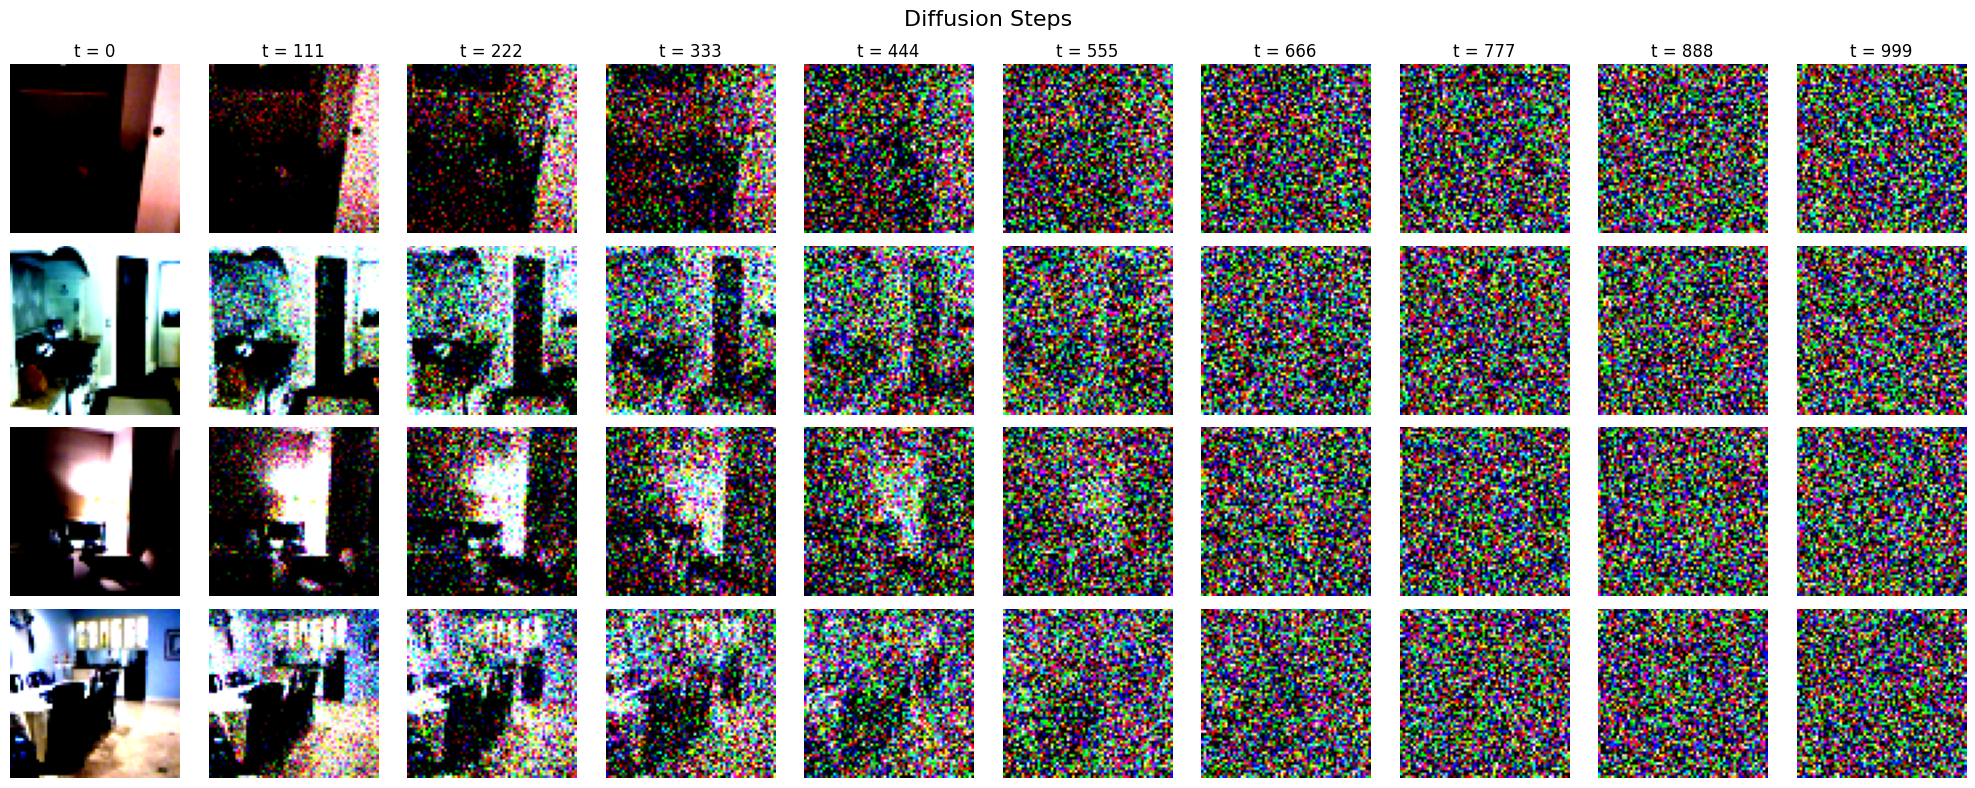

In [18]:
from torchvision.transforms.functional import to_pil_image

def plot_diffusion_steps(diffusion, images, device="cuda"):
    images = images.to(device)
    num_images = images.size(0)

    steps = torch.linspace(0, diffusion.noise_steps - 1, 10).long()

    fig, axes = plt.subplots(num_images, 10, figsize=(20, 2 * num_images))
    fig.suptitle("Diffusion Steps", fontsize=16)

    with torch.no_grad():
        for img_idx in range(num_images):
            image = images[img_idx].unsqueeze(0)

            for step_idx, t in enumerate(steps):
                t = t.unsqueeze(0).to(device)

                noised_image, _ = diffusion.noise_images(image, t)

                img_pil = to_pil_image(noised_image.squeeze(0).cpu().clamp(0, 1))

                if num_images > 1:
                    axes[img_idx, step_idx].imshow(img_pil)
                    axes[img_idx, step_idx].axis("off")
                    if img_idx == 0:
                        axes[img_idx, step_idx].set_title(f"t = {t.item()}")
                else:
                    axes[step_idx].imshow(img_pil)
                    axes[step_idx].axis("off")
                    axes[step_idx].set_title(f"t = {t.item()}")

    plt.tight_layout()
    plt.show()

plot_diffusion_steps(diffusion, torch.stack([train_dataset[i][0] for i in range(4)]), device)

As can be seen, at $t=0$ the scene is clearly visible. Then gradually as $t$ increases, the image becomes more noisy and the scene turns into just a purely noisy signal. Of course, the images here are already normalized and standardized as this is what the model will see.

The model will be fed one such noisy image at each step. The gradient will be calculated based on the model's noise prediction $\hat{\epsilon}$ and the corresponding noise $\epsilon$ ("ground truth") that has been added by the scheduler. It will thus try to learn the noise that has been added at step $t$. 

**Note**: I implemented the scheduler to apply **linear noise**, just like proposed in the DDPM paper. A later paper ["Improved Denoising Diffusion Probabilistic Models" by Nichol & Dhariwal of OpenAI in 2021](https://arxiv.org/pdf/2102.09672) mentioned how this linear noise forward process can be too harsh. The plot above also shows that between $t=666$ and $t=777$ the images already become almost pure noise, making the timesteps $t>777$ (in this case) pretty much unnecessary as we just start to add more noise on top of already pure noise. Thus, Nichol & Dhariwal introduced a *"Cosine Schedule"* which turns out to distribute the noise over $T$ timesteps much more equally. I just wanted to mention this finding as this could be an improvement for my implementation.

## Training Setup
To train the models on the NYU Depth v2 dataset, I have constructed a system of **three main components** that I explain in this section.

### Trainer
The [`Trainer`](trainer.py) class is responsible for orchestrating the training of the DDPM U-Net model. It manages everything from data loading to logging and model checkpointing. By integrating with Weights & Biases (wandb) and an EMA (Exponential Moving Average) model, the training loop remains both trackable and consistent.
- It handles the core training loop, including noise injection, loss calculation (MSE on predicted noise), and parameter updates.
- It maintains an EMA variant of the model, which can often produce better samples due to more stable weights.
- It validates the model at the end of each epoch and logs metrics (FID, PSNR, etc.) for thorough performance monitoring.
- It provides sampling methods to generate and log images, letting you visualize the model’s progression in learning conditional generation.
- It saves checkpoints when it encounters improved validation performance, storing both the standard and EMA model weights.

### train.py
The [`train.py`](train.py) script is the main entry point that brings together the dataset, the model, the diffusion process, and the training configuration—particularly through Hydra. It allows me to override default configuration settings directly via command-line arguments.

- It loads and configures the NYU Depth V2 dataset based on pre-defined ratios for splitting into training, validation, and testing.
- It initializes the model and diffusion process, creating a Diffusion object with the specified noise schedule.
- It instantiates and configures an optimizer (and optionally a scheduler) using Hydra’s instantiation utilities.
- It creates a [`Trainer`](trainer.py) instance and calls its `run()` method, which executes the entire training and validation process.
- Finally, it tests the model on the test split using the trained/EMA weights.

### Hydra
Hydra is used to manage configuration files—these can be changed or extended without needing to alter code. The [`/scripts`](./scripts/) directory contains helper scripts for simplifying tasks on the Slurm cluster environment.

- The **Hydra configs** specify hyperparameters (like learning rate, batch size, epochs), model configurations, data paths, and additional experiment settings.
- You can **launch different experiments** by choosing the appropriate config or overriding parameters on the command line, making it easy to keep track of various runs.
- The [`/scripts`](./scripts/) directory includes utilities for packaging the codebase, uploading files to the Slurm cluster, and submitting new jobs. This ensures a streamlined workflow for running multiple experiments in a high-performance computing environment.

## Models
In this section I go through the models I have explored during this mini challenge. This is where I use the [Analyzer](./analyzer.py) class which can retrieve logs from W&B, print out a "model receipt" which contains information on the archtiectures and later on sample new images.

The following models all follow a U-Net structure including the time-projection embedding `t_proj` as well as the class and depth embedding layers (`class_emb` and `depth_emb`) for the conditioning vectors.

### Exponential Moving Average Updated Models
Each of the following models also was additionally updated with an EMA model. This is something I discovered in the OpenAI paper ["Improved Denoising Diffusion Probabilistic Models"](https://arxiv.org/pdf/2102.09672) and since it was relatively cost efficient to implement and update in parallel to the regular model I decided to also implement this inside [./core/utils.py](./core/utils.py).

My DDPMs involve training a U-Net to predict noise during diffusion. To improve stability and generalization, an EMA model tracks the U-Net's parameters during training.

Moving Average Updates: As the U-Net's parameters (model) are updated during training, the EMA model (ema_model) smooths these updates using the formula: $$EMA_t=\beta\cdot EMA_{t-1}+(1-\beta)\cdot\text{Current}$$
Where $\beta$ is a smoothing decay factor, in my case, like the paper at $\beta=0.995$.

This update rule is thought to capture a more stable version of the U-Net over time as its averaging counters noisy updates during training.

### U-Net Baseline
First, I am interested in how many parameters this task will need. Thus, I am first introducing a "Baseline U-Net" ([UNet_Baseline](./core/unet_baseline.py)) with just a few parameters and of one U-Net depth (one Down and one Up block):

In [19]:
from analyzer import Analyzer

from core import UNet_Baseline

unet_baseline_analyzer = Analyzer(model=UNet_Baseline(num_classes=18).to(device), device=device)

unet_baseline_analyzer.model_receipt()

--- Model Receipt for UNet_Baseline ---
Total parameters: 1771907
Trainable parameters: 1771907
Non-trainable parameters: 0
Device: cuda:0

Model Architecture:

UNet_Baseline(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(1, 64, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): GroupNorm(1, 64, eps=1e-05, affine=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): GroupNorm(1, 64, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

### Vanilla U-Net

The second module is a Vanilla U-Net following the same architecture as proposed in the original DDPM paper but without Attention blocks. With `22498179` tunable parameters it has significantly more variance than the previous Baseline U-Net. 

In [20]:
from core import UNet

unet_analyzer = Analyzer(model=UNet(num_classes=18).to(device), device=device)

unet_analyzer.model_receipt()

--- Model Receipt for UNet ---
Total parameters: 22498179
Trainable parameters: 22498179
Non-trainable parameters: 0
Device: cuda:0

Model Architecture:

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(1, 64, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): GroupNorm(1, 64, eps=1e-05, affine=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): GroupNorm(1, 64, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

### Attention U-Net

And as a third model, or rather second next to the Vanilla U-Net, this is now the same U-Net as the Vanilla U-Net but with `SelfAttention` layers which compute dependencies between all positions in the feature map. This helps in understanding relationships across distant pixels, which is particularly useful for maintaining coherence in images that require class-specific or depth-specific structures like at hand.

In [21]:
from core import UNet_Attn

unet_attn_analyzer = Analyzer(model=UNet_Attn(num_classes=18).to(device), device=device)

unet_attn_analyzer.model_receipt()

--- Model Receipt for UNet_Attn ---
Total parameters: 23539331
Trainable parameters: 23539331
Non-trainable parameters: 0
Device: cuda:0

Model Architecture:

UNet_Attn(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(1, 64, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): GroupNorm(1, 64, eps=1e-05, affine=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): GroupNorm(1, 64, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padd

## Results
This section will present the training results and metrics.

Before looking at the results though, I will extract 5 class and depth vectors from the test partition, which the models have not seen at any time during training or optimization, to later on feed into the sampling process to assess their image generation:

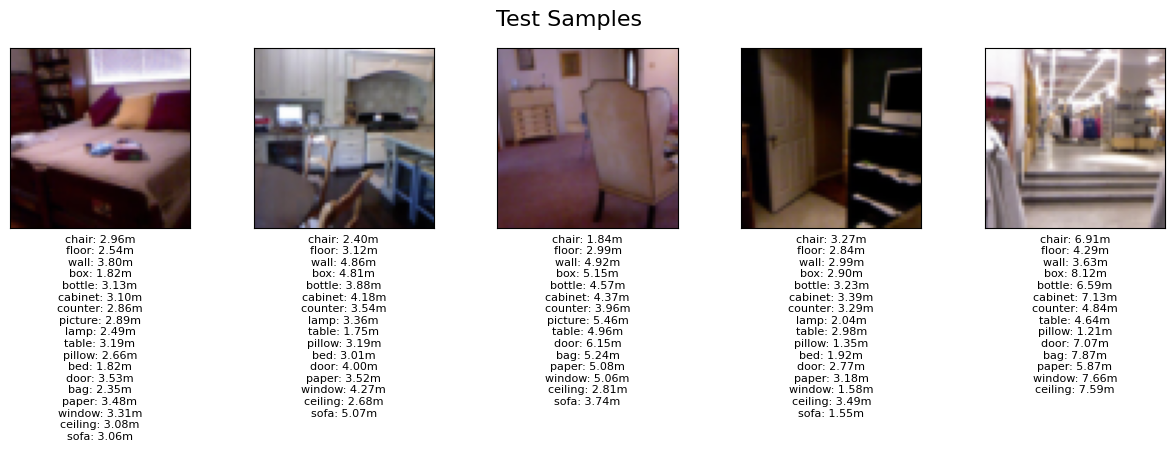

In [22]:
from data.utils import unnormalize

N_SAMPLES = 5

sample_images = [test_dataset[i] for i in range(N_SAMPLES)]

fig1, axes1 = plt.subplots(1, N_SAMPLES, figsize=(N_SAMPLES * 3, 3))
fig1.suptitle("Test Samples", fontsize=16)

for i in range(N_SAMPLES):
    ax = axes1[i]
    ax.imshow(unnormalize(sample_images[i][0].cpu(), mean, std).permute(1, 2, 0))
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    class_vector = sample_images[i][3]
    depth_vector = sample_images[i][4]

    present_classes = [dataset.resolved_names[j] for j in range(len(class_vector)) if class_vector[j] == 1]
    depths = [depth_vector[j] for j in range(len(class_vector)) if class_vector[j] == 1]

    label_text = "\n".join([f"{cls}: {depth:.2f}m" for cls, depth in zip(present_classes, depths)])

    ax.set_xlabel(label_text, fontsize=8)

plt.subplots_adjust(bottom=0.25, top=0.85, wspace=0.3)
plt.show()

The selected samples show a fairly balanced variety on lighting conditions, scenes (with different objects) as well as a range of depths. 

In [23]:
sample_classes = torch.stack([torch.tensor(sample_images[i][3]) for i in range(N_SAMPLES)]).to(device)
sample_depths = torch.stack([torch.tensor(sample_images[i][4]) for i in range(N_SAMPLES)]).to(device)

### Overfit Tests
The first training milestone is to look at the ability of each model to learn and memorize the dataset. This was done using `16` training images with a batch size of `4` during `5000` epochs for all three models. I have ran this first overfit experiment locally with just 8GB of VRAM, hence the low batch size.

#### Overfitting U-Net Baseline
The expected outcome is that the model, out of all three, will probably overfit the fastest as it has the lowest variance (or lowest number of parameters).

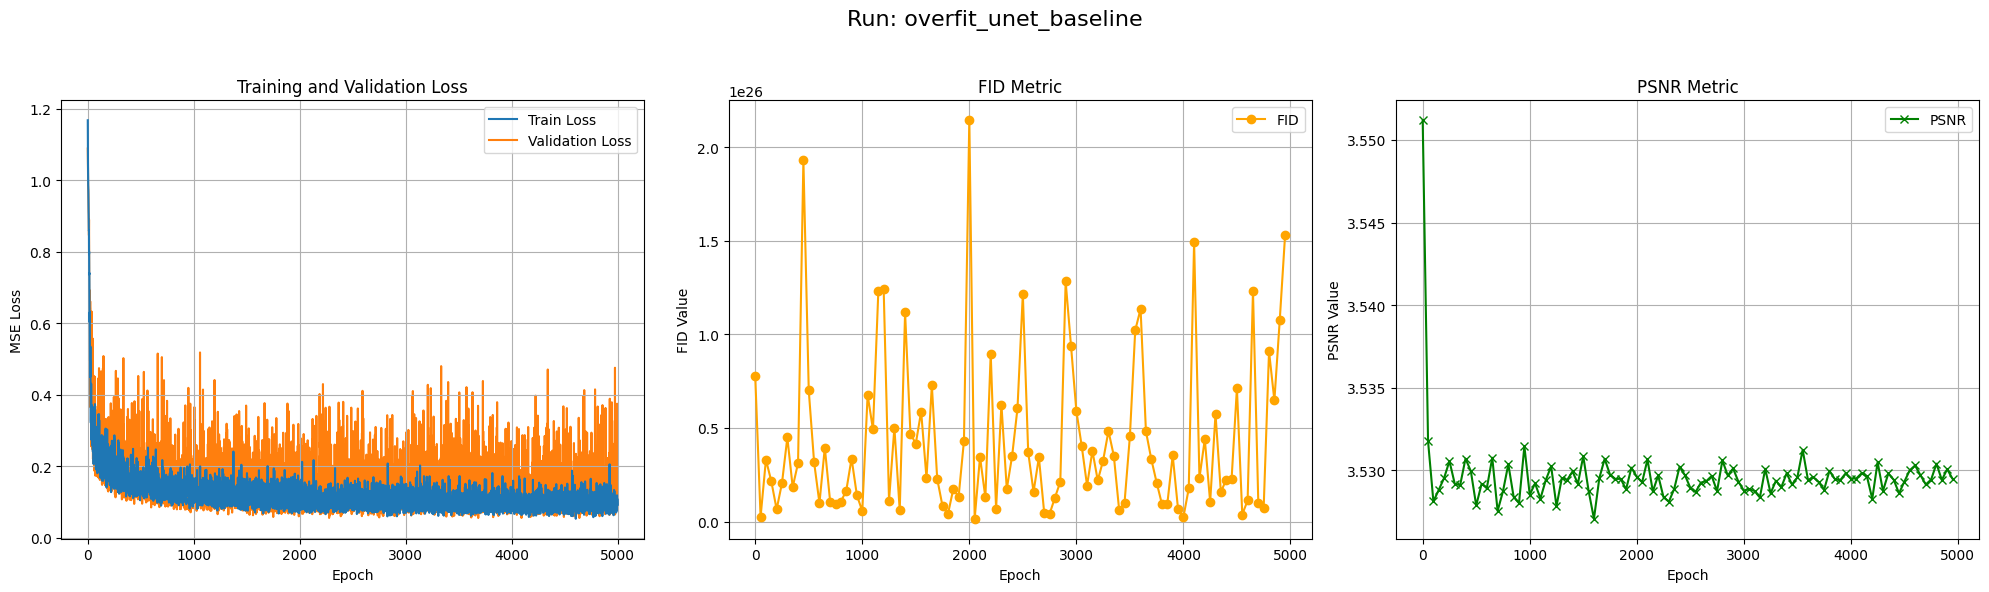

In [24]:
unet_baseline_analyzer.plot('7ap8tsqm')

The plot above shows very noisy loss curves - This is most likely due to the low batch size. Overall, the validation loss does not show signs of overfitting. The Frechet Inception Distance and PSNR is also really noisy and does not show clear convergence.

In [25]:
%wandb okaynils/vdl/reports/Validation-Samples-overfit_unet_baseline--VmlldzoxMDgyMzQwNw

When looking at the logged validation samples, the samples get less noisy throughout the epochs but seem to converge to one tone of color with little to no structure,  dissimilar to the real images.

12:27:01 - INFO: Sampling 5 new images from UNet_Baseline...



Searching for model weights for run 7ap8tsqm...
Found default model: overfit_unet_baseline_7ap8tsqm.pth!
Found EMA model: overfit_unet_baseline_ema_7ap8tsqm.pth!


999it [00:09, 99.93it/s] 
12:27:11 - INFO: Sampling 5 new images from UNet_Baseline...
999it [00:09, 108.99it/s]


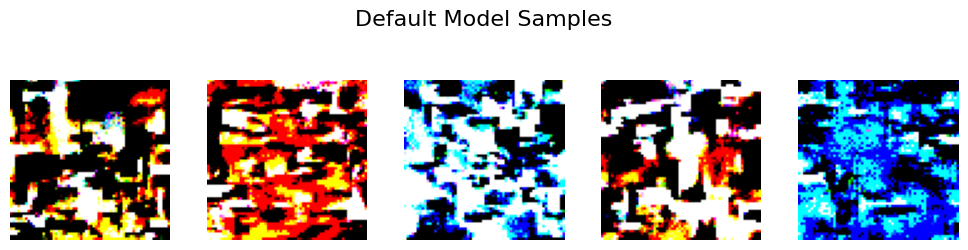

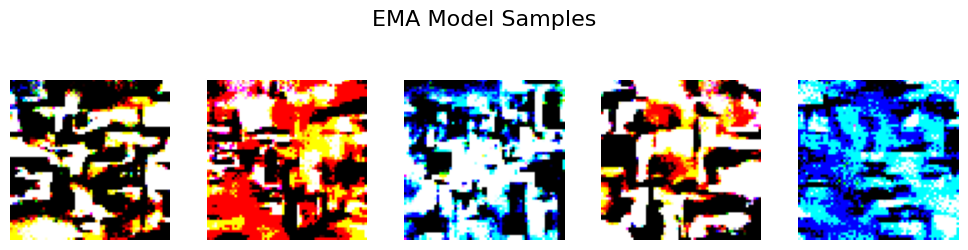

In [26]:
unet_baseline_analyzer.sample_images('7ap8tsqm', sample_classes, sample_depths)

The sampled images show the diffusion capability of the model at its **lowest validation loss**, so these samples are presumably worse than the W&B output showing the last step, which at least converges into the color tone of most of the dataset.

I suspect the Baseline U-Net just does not have enough parameters yet to overfit on even such a small batch of images.

#### Overfitting Vanilla U-Net
Contrary to the first overfitting experiment, this Vanilla U-Net should be more promising to overfit. It was trained on the same configurations, without any regularization, just a bare-bone U-Net with conditional embeddings.

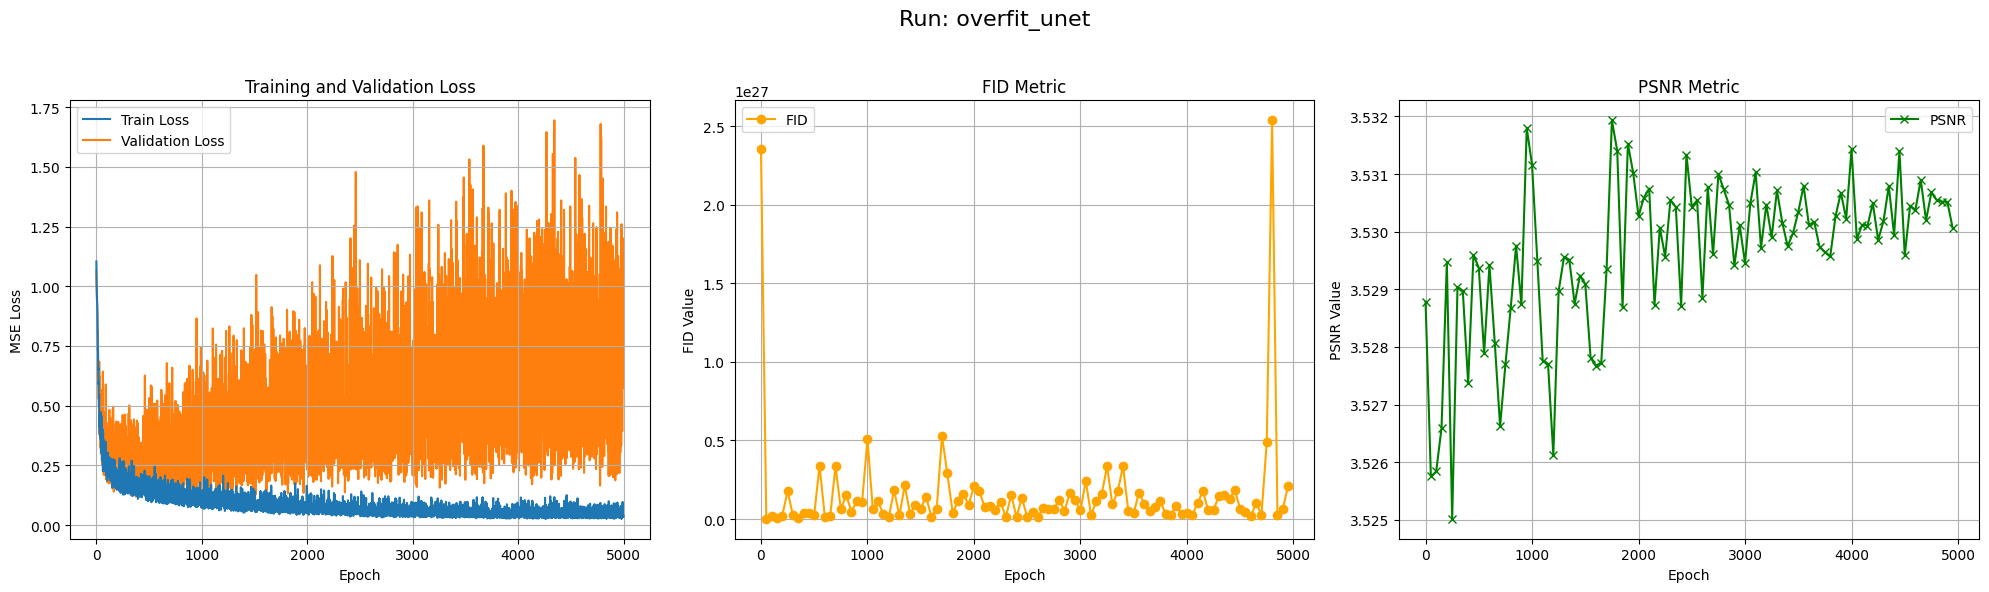

In [27]:
unet_analyzer.plot('llsehnp2')

Similar to above, we can see a very noisy loss but the validation curve now clearly shows overfitting which stars somewhere during the first `1000` epochs. The FID metric seems to decrease close to 0 in some epochs, suggesting that there is an overfit, or at least closer resemblance between the real and synthesized images. The PSNR also rises a little which could be due to the effective overfitting that now has less noise. 

**Note**: It's hard to tell what values the FID actually takes on as the y-scale goes up to $1\times 10^{27}$. I am more interested in the general trend of the metric as I am using the `inception_v3` model to measure the distances, which was trained on ImageNet, a dataset which is more closely related to one-object images unlike rooms filled with many objects.

In [28]:
%wandb okaynils/vdl/reports/Validation-Samples-overfit_unet--VmlldzoxMDgyMzU0OA

The validation samples at the last epoch now starts to show structures of some images. Most images seem to diffuse the same or a very similar scene with what looks to be a bookshelf.

To train the overfitting models, I have taken the first 24 images of the dataset, those were partitioned into a training, validation and testing partition with the afforementioned `16` images going to the training parititon. The following plot should an image that looks similar to what we see in the overfitted model's validation results.

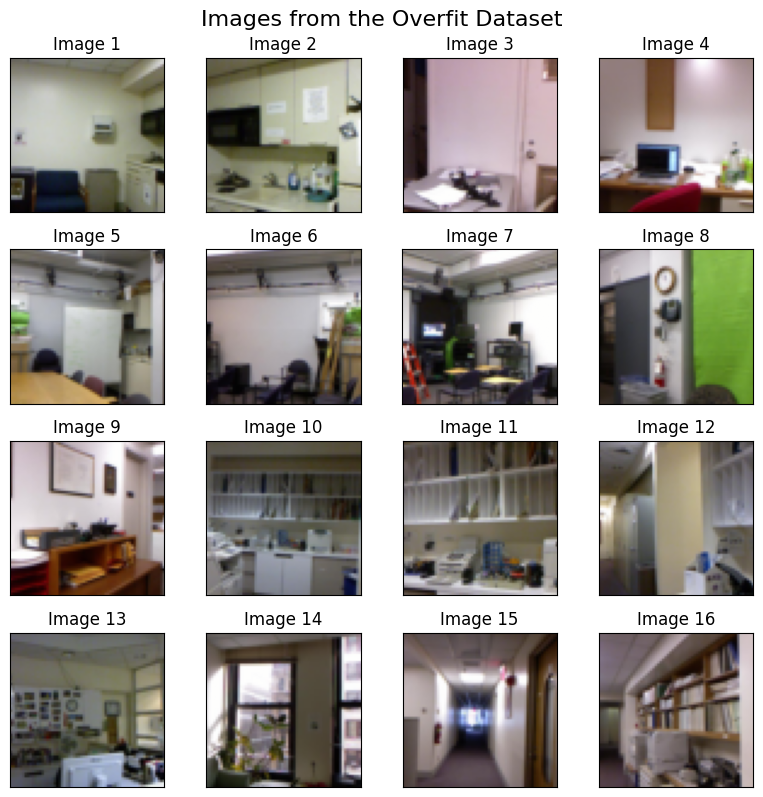

In [29]:
fig = plt.figure(figsize=(8, 12))
for i in range(16):
    ax = fig.add_subplot(6, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(unnormalize(dataset[i][0].cpu(), mean, std).permute(1, 2, 0))
    ax.set_title(f"Image {i+1}")
    
plt.suptitle("Images from the Overfit Dataset", fontsize=16)
plt.tight_layout()
plt.show()

Image 10 shows the same bookshelf and cabinet below it which was predominantly generated in the overfitted Vanilla U-Net. Image 11 also shows the same scene more closer up as well as Image 12 but from a slightly different angle. The fact that the model mainly generates overfit images on this Image 10 could be due to that bias; This scene exists 2 times in different variants in this dataset.


Searching for model weights for run llsehnp2...
Found EMA model: overfit_unet_ema_llsehnp2.pth!
Found default model: overfit_unet_llsehnp2.pth!


12:27:31 - INFO: Sampling 5 new images from UNet...
999it [00:13, 75.68it/s]
12:27:44 - INFO: Sampling 5 new images from UNet...
999it [00:13, 74.83it/s]


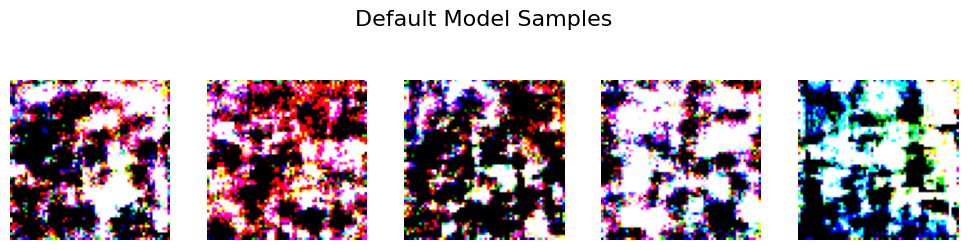

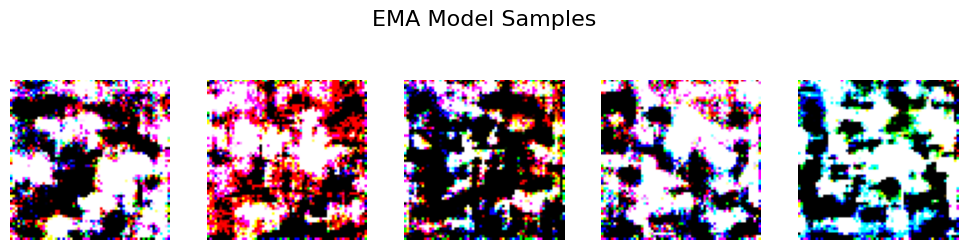

In [30]:
unet_analyzer.sample_images('llsehnp2', sample_classes, sample_depths)

And similar to the experiment of overfitting the baseline U-Net, this time the Vanilla U-Net doesn't show more promising results when sampling from the model at its lowest validation loss.

#### Overfitting Attention U-Net
The last model to perform an overfit on is the Attention U-Net. I expect it to behave similarly to the Vanilla U-Net as it even has about `1M` more parameters.

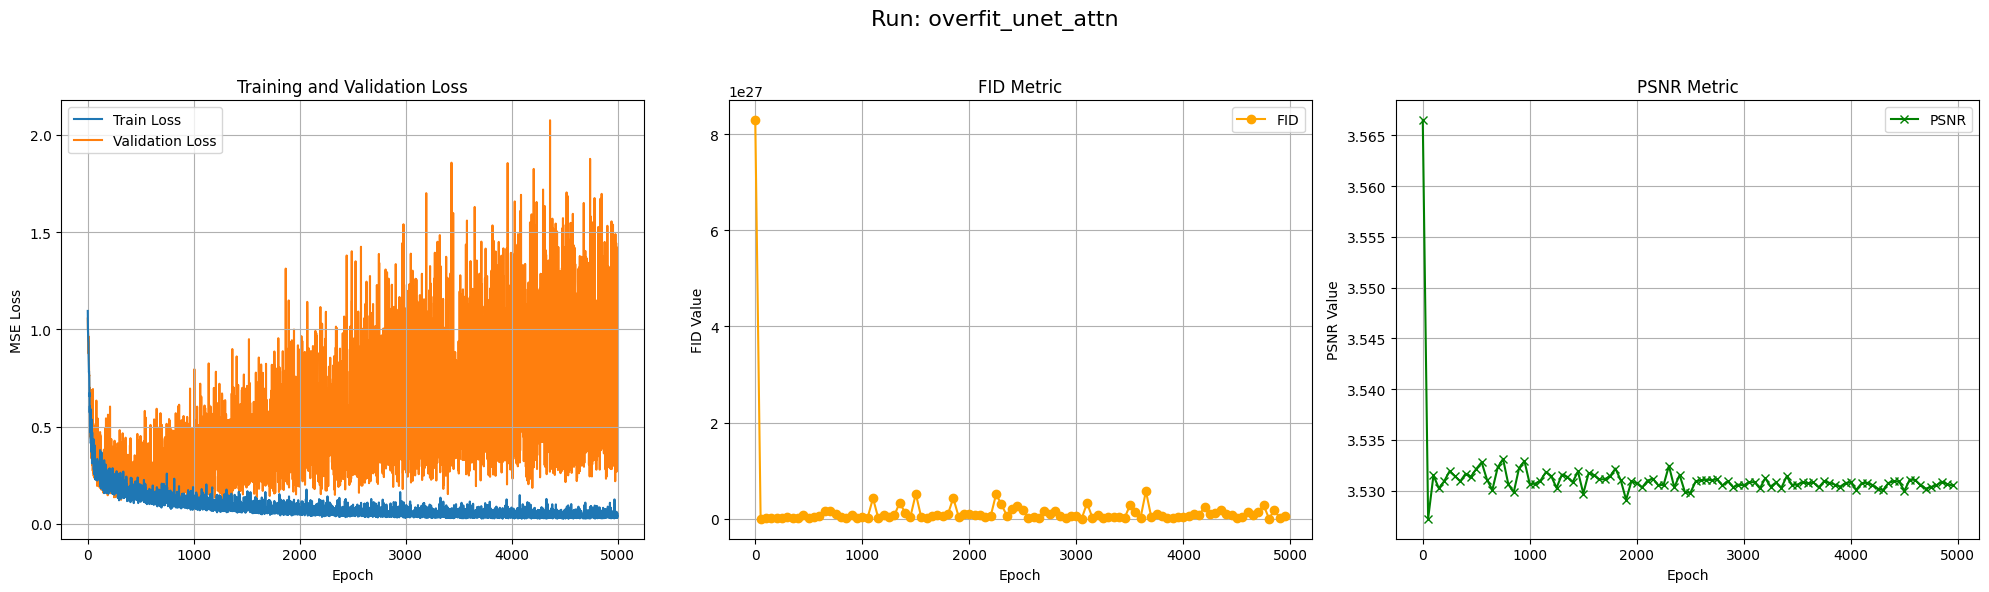

In [31]:
unet_attn_analyzer.plot('k82fjz9d')

The loss curves are also here very noisy due to the low batch size but the validation loss moves into an overfit regime quickly. The metrics are also similar to the previous experiment. The FID especially shows less noise and is overall closer to 0 than in the Overfit experiment of the Vanilla U-Net. This could just be due to the additional parameters or the attention mechanism which can take up on more detail and relationships in the images.

In [32]:
%wandb okaynils/vdl/reports/Validation-Samples-overfit_unet_attn--VmlldzoxMDgyMzU1OA

And also in the validation samples of the overfit Attention U-Net, Image 10 again shines through predominantly. This time, the default model (not EMA) also once generated a replica of Image 16.


Searching for model weights for run k82fjz9d...
Found EMA model: overfit_unet_attn_ema_k82fjz9d.pth!
Found default model: overfit_unet_attn_k82fjz9d.pth!


12:28:07 - INFO: Sampling 5 new images from UNet_Attn...
999it [00:55, 18.14it/s]
12:29:02 - INFO: Sampling 5 new images from UNet_Attn...
999it [00:53, 18.78it/s]


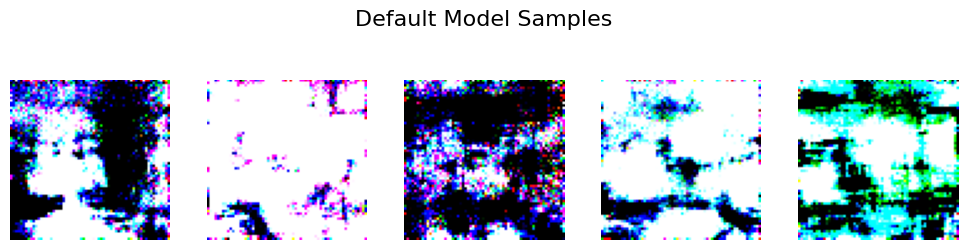

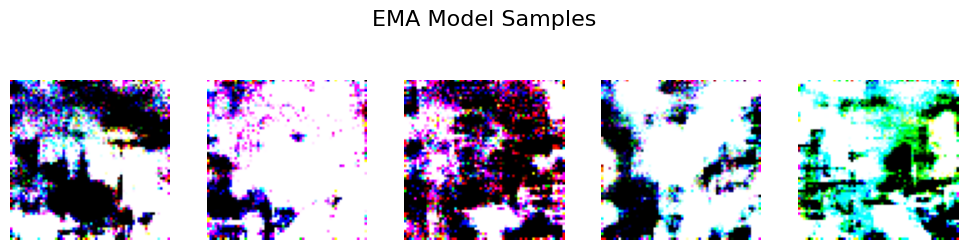

In [33]:
unet_attn_analyzer.sample_images('k82fjz9d', sample_classes, sample_depths)

Last but not least, the generated images of the Attention U-Net model at its lowest validation loss neither shows interesting results.

#### Summary of Observations
- The Baseline U-Net model has too few parameters to even overfit on a small fraction of the dataset.
    - I will therefore not use this model for further experiments.
- Both the Vanilla and Attention U-Net are overfitting on the dataset. 
- The Frechet Inception Distance shows that the it's more stable towards 0 for the Attention U-Net which could be due to its ability to capture details in a more meaningful way.
- All three experiments yielded brown-toned images when they overfitted on the dataset. This is not something I have expected as I am standardizing and normalizing the inputs before passing them into the model. This could be just due to the nature of the dataset, which contains mostly warm tones and maybe tries to mix together these colors when overfitting. The overall structures can still be seen on most generated validation samples.
- The generated samples of the models at their lowest validation loss however don't show any interesting results yet.

### Training the Models on the entire training partition
Now that I am training with `1014` images (70% of 1449) the training should need less epochs to generalize. So the configuration for the following experiments decrease the number of epochs from `5000` to `500`. Additionally, I increase the batchsize from just `4` samples per batch to `16` for the Vanilla U-Net as I train the next experiments on a Slurm cluster with GPUs that have >10GB VRAM. I wasn't able to do the same for the runs that trained the Attention U-Net since I again ran into memory issues, thus having to keep the Attention U-Net's experiments at a batch size of `4`. The models stay unchanged in their configuration.

#### Training Vanilla U-Net

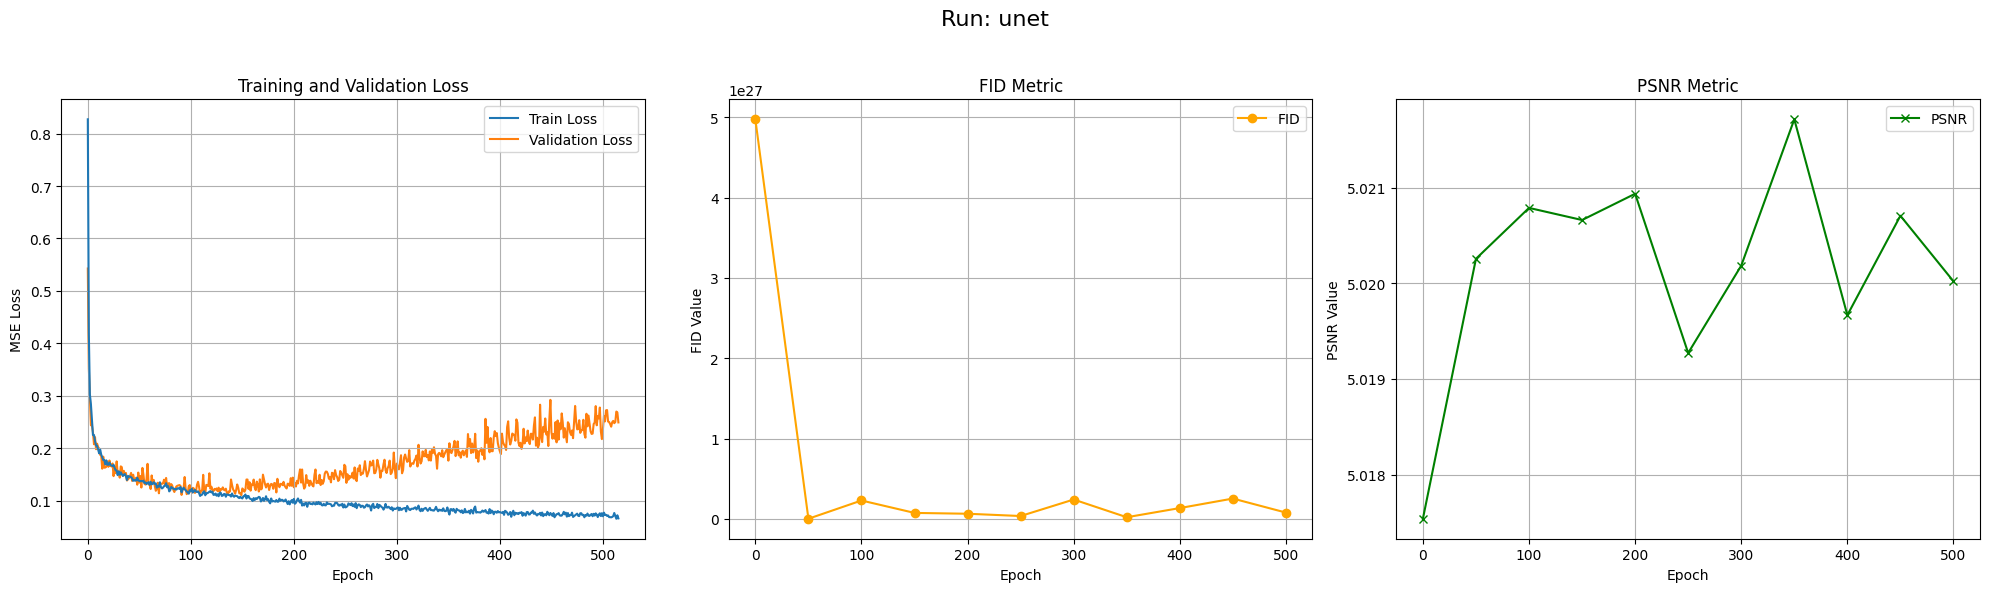

In [34]:
unet_analyzer.plot('nw2ak8nu')

The Vanilla U-Net now shows a much less noisy loss but still overfits. This time the validation loss starts moving into an overfit regime at around epoch `130`. Both metrics are still quite similar to the overfit tests.

In [41]:
%wandb okaynils/vdl/reports/Validation-Samples-unet--VmlldzoxMDgyMzU5Mw

In the validation samples of the Vanilla U-Net trained on all available training images the model still seems to collapse to a brown-toned color space. The late validation samples show some structures but arent clearly overfitting to just one training image anymore. It might be a mixture of multiple high-bias sceneries.

If we move the slider to around epoch 100-150, where the validation loss is the lowest, we can see a more diverse color space (although not by much). Some hints of structures shine through but its not clear what they represent. I would guess these may stem from bookshelves that contain book covers of many colors.

### Training Attention U-Net

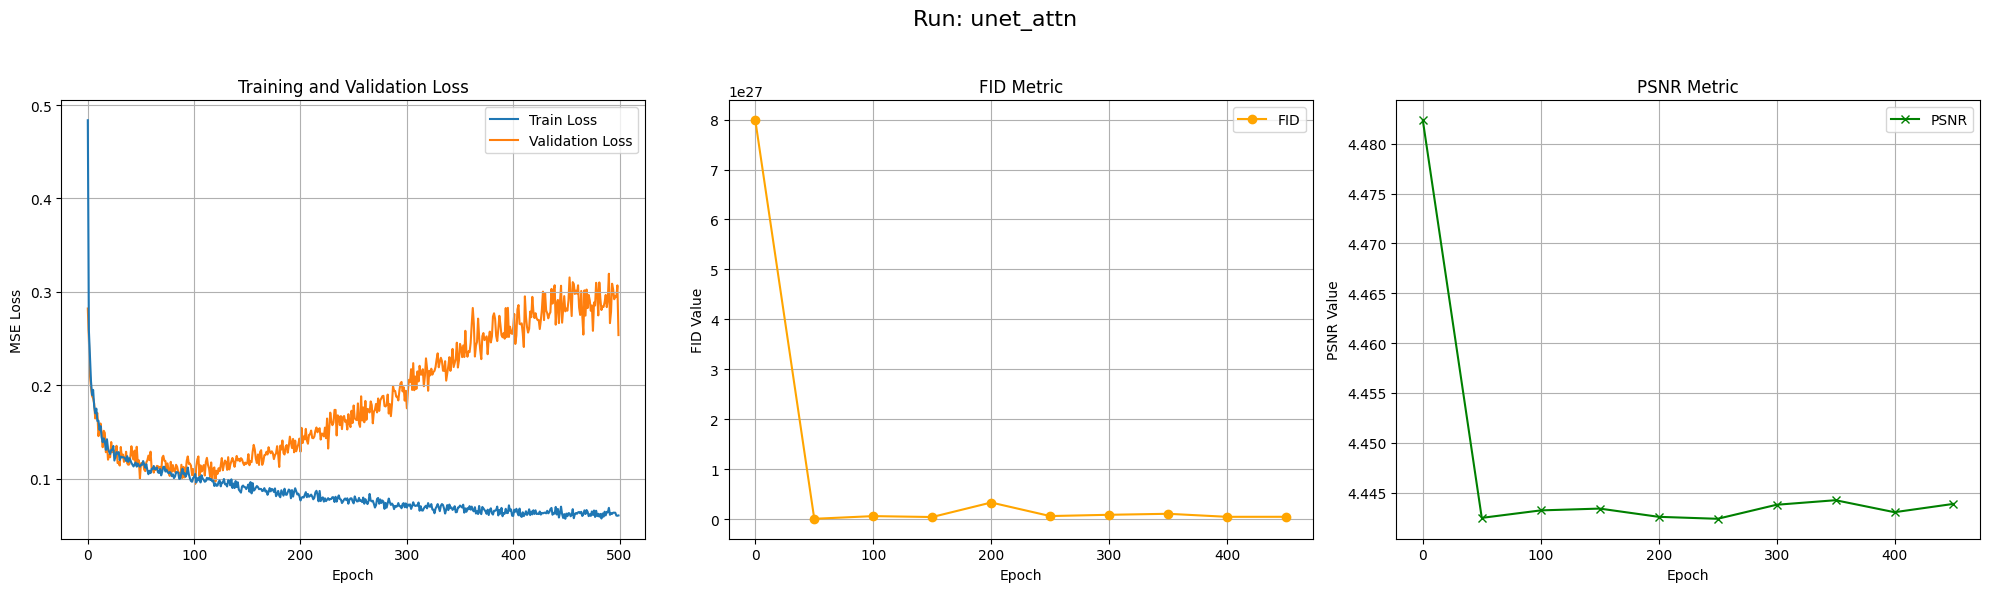

In [36]:
unet_attn_analyzer.plot('jedb7cv5')

The Attention U-Net also shows smoother loss curves, and also here the validation loss shows overfitting. This time the smoother loss curve likely emerges from the higher variance of the full dataset. The FID also decreases from the first epoch to epoch 50 but then stays fairly stable which suggests some improvement however the PSNR does not really show any significant change as the decrease is in the small decimals.

In [37]:
%wandb okaynils/vdl/reports/Validation-Samples-unet_attn--VmlldzoxMDgyMzYxNw

The validation samples show a similar result to the ones in the previous Vanilla U-Net experiment. The model collapses into a single toned color space. At around epoch ~100 the samples also show some hints of objects. This time maybe even a tiny bit clearer - Perhaps due to attention.

#### Summary of Observations
- Adding more samples to training got rid of the noisy loss curves.
- The single color tone still persists.
- The FID still decreases signaling some sort of improvement however the PSNR doesn't move by a lot.
- Both models still overfit, so the next addition I will make is adding regularization through `Dropout`.

### Regularizing Vanilla U-Net

In [38]:
# TODO

### Regularizing Attention U-Net

Configuration `dropout_rate=0.2`

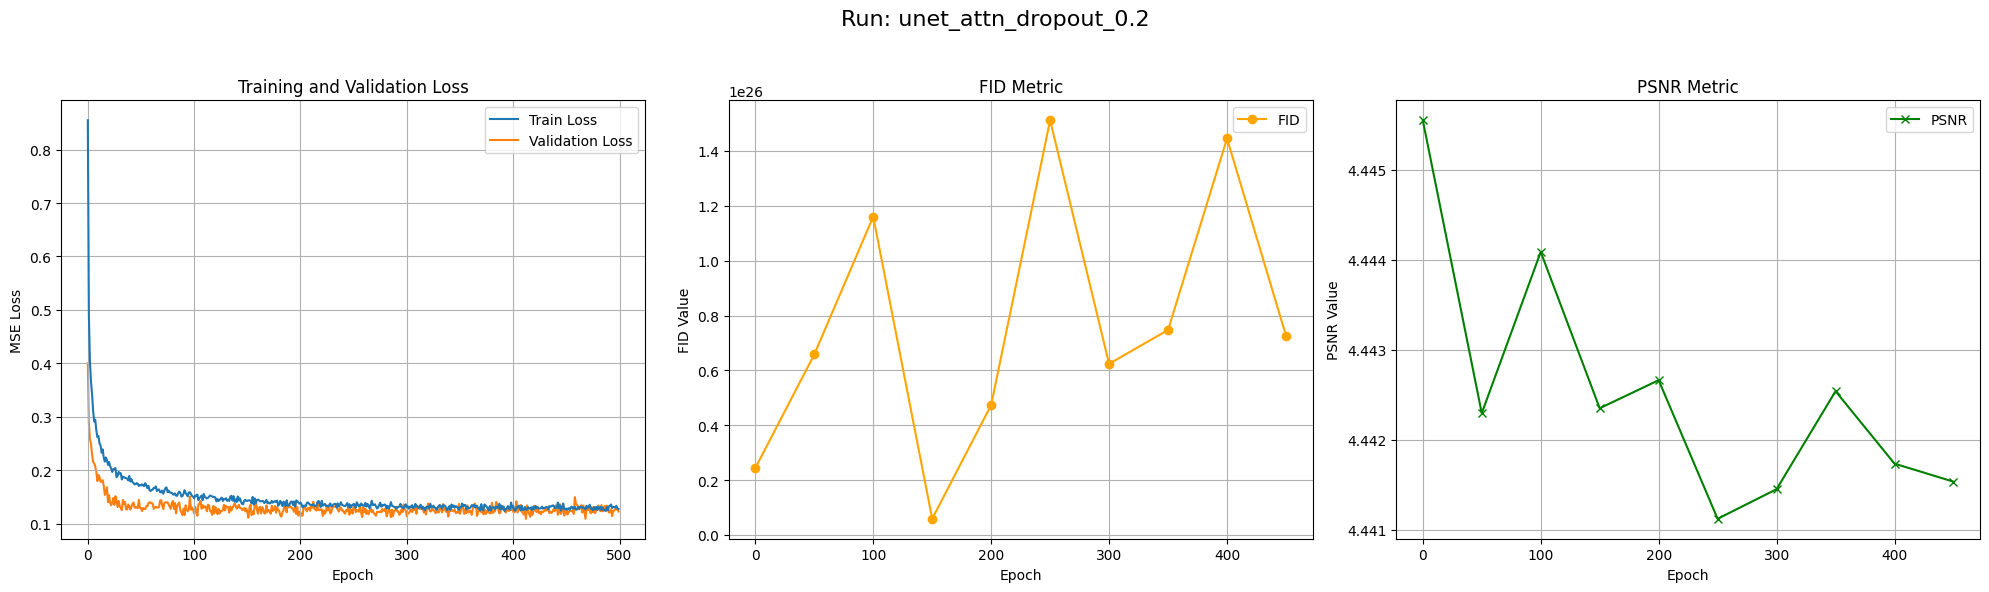

In [39]:
unet_attn_analyzer = Analyzer(model=UNet_Attn(num_classes=18, dropout_prob=.2).to(device), device=device)
unet_attn_analyzer.plot('eicmnjop')

The validation loss now constantly converges without showing any signs of overfit. It overall is lower than the training loss, which at first looks suspicious but makes sense when we take into consideration that Dropout was added, which inflates the training error. 

The Frechet Inception Distance shows a fluctuating pattern during training which is surprising as the loss curves show a relatively stable convergence. The PSNR again shows no significant change.

In [40]:
%wandb okaynils/vdl/reports/Validation-Samples-unet_attn_dropout_0-2--VmlldzoxMDgyMzc5Ng

The validation samples now show some more room-like structures in the images but the problem with colors still applies which makes it hard to see what objects these structures represents and at what depth they lie.